# Wind exposure plot

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [11]:
import json
from datetime import datetime
from zoneinfo import ZoneInfo

import geopandas as gpd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np

from src.datasources.meteofr import (
    parse_track_json,
    prepare_wind_contours,
    expand_quad_col,
    calculate_wind_buffers_gdf,
)
from src.monitoring.plotting import plot_bullseye_exposures, plot_wind_buffers
from src.utils.exposure import calculate_multi_adm_exposure
from src.utils.blob_utils import PROJECT_PREFIX

## Load data

### CODAB

In [3]:
adm1 = stratus.codab.load_codab_from_fieldmaps(iso3="mdg", admin_level=1)

<Axes: >

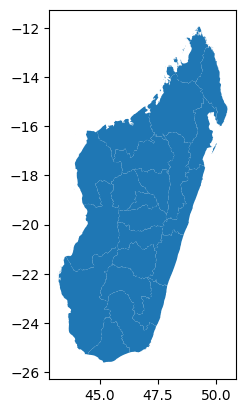

In [4]:
adm1.plot()

### Meteo France track forecast

In [5]:
blob_name = (
    "RSMC_LaReunion/CMRSTRACK_SWI$10_20252026_10-20252026_2026_02_05_12Z.json"
)
data = stratus.load_blob_data(blob_name, container_name="meteofr")

In [6]:
fcast_dict = json.loads(data)

In [7]:
records, fc_details, uncertainty_cone = parse_track_json(fcast_dict)

In [8]:
speeds = [28, 34, 48, 64]

In [12]:
records = prepare_wind_contours(records)

for speed in speeds:
    col = f"wind_contour_{speed}kt"
    records = expand_quad_col(records, col)

In [14]:
records["lon"] = records.geometry.x
records["lat"] = records.geometry.y

### WP

In [15]:
blob_name = "worldpop/pop_count/global_pop_2026_CN_1km_R2025A_UA_v1.tif"
da_wp_global = stratus.open_blob_cog(blob_name, container_name="raster")

In [16]:
da_wp = da_wp_global.rio.clip(adm1.geometry).squeeze(drop=True).compute()

In [17]:
da_wp.attrs["_FillValue"] = None
da_wp = da_wp.where(da_wp > 0)

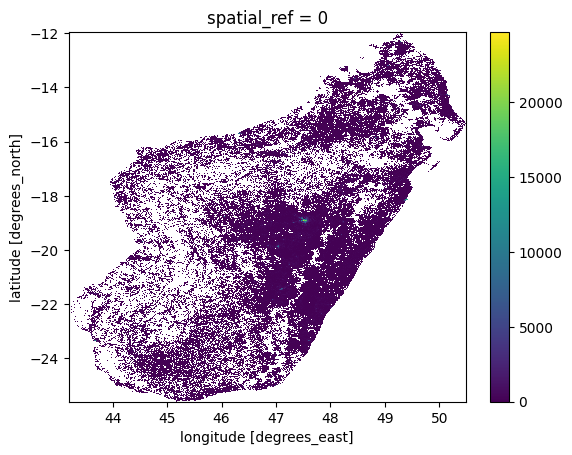

In [18]:
da_wp.plot()

In [19]:
da_wp.sum()

<xarray.DataArray ()> Size: 4B
array(32938792., dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     None

### Bubbles Template

In [20]:
blob_name = f"{PROJECT_PREFIX}/processed/plotting/adm1_template.parquet"
template_df = stratus.load_parquet_from_blob(blob_name)

## Calculate exposure

### Calculate wind buffers

In [21]:
gdf_buffers = calculate_wind_buffers_gdf(
    records,
    valid_time_col="time",
    quad_cols_format="wind_contour_{speed}kt_{quad}",
    lat_col="lat",
    lon_col="lon",
    speeds=speeds,
)

In [22]:
gdf_buffers

,speed,geometry
0,28,"MULTIPOLYGON (((5647803.403 -2692831.508, 5638..."
1,34,"POLYGON ((5660078.103 -2461207.909, 5654607.53..."
2,48,"POLYGON ((5658831.755 -2296088.983, 5656259.77..."
3,64,"POLYGON ((5672248.965 -2254612.17, 5670310.606..."


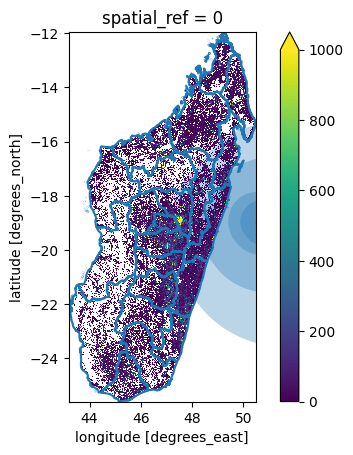

In [23]:
fig, ax = plt.subplots()
gdf_buffers.to_crs(4326).plot(ax=ax, alpha=0.3)
records.plot(ax=ax)
adm1.boundary.plot(ax=ax)
da_wp.plot(ax=ax, vmax=1000)

### Overlay and calculate exposure

In [24]:
df_exp = calculate_multi_adm_exposure(
    gdf_buffers, da_wp, adm1, adm_index="adm1_src", disable_tqdm=False
)

  0%|          | 0/22 [00:00<?, ?it/s]

In [25]:
df_exp

,speed,pop_exposed,adm1_src
0,28,4453505,MG11
1,34,0,MG11
2,48,0,MG11
3,64,0,MG11
4,28,1104991,MG12
...,...,...,...
83,64,0,MG71
84,28,24658,MG72
85,34,0,MG72
86,48,0,MG72


In [26]:
df_exp["speed_kmh"] = (df_exp["speed"] * 1.852).astype(int)

In [27]:
df_exp["speed_kmh"].unique()

array([ 51,  62,  88, 118])

In [28]:
df_exp

,speed,pop_exposed,adm1_src,speed_kmh
0,28,4453505,MG11,51
1,34,0,MG11,62
2,48,0,MG11,88
3,64,0,MG11,118
4,28,1104991,MG12,51
...,...,...,...,...
83,64,0,MG71,118
84,28,24658,MG72,51
85,34,0,MG72,62
86,48,0,MG72,88


## Plot

In [29]:
colors = {51: "gold", 62: "darkorange", 88: "crimson", 118: "indigo"}

In [30]:
colors.keys()

dict_keys([51, 62, 88, 118])

In [31]:
fc_details

{'cyclone_name': '10-20252026',
 'season': 20252026,
 'reference_time': '2026-02-05T12:00:00Z',
 'basin': 'SWI'}

In [32]:
def dt_to_EAT(s):
    dt_utc = datetime.fromisoformat(s.replace("Z", "+00:00"))
    return dt_utc.astimezone(ZoneInfo("Africa/Nairobi"))

In [33]:
dt_eat = dt_to_EAT(fc_details["reference_time"])

In [34]:
issued_time_str = dt_eat.strftime("%Y-%m-%d %H:%M")

In [35]:
gdf_buffers["speed_kmh"] = (gdf_buffers["speed"] * 1.852).astype(int)

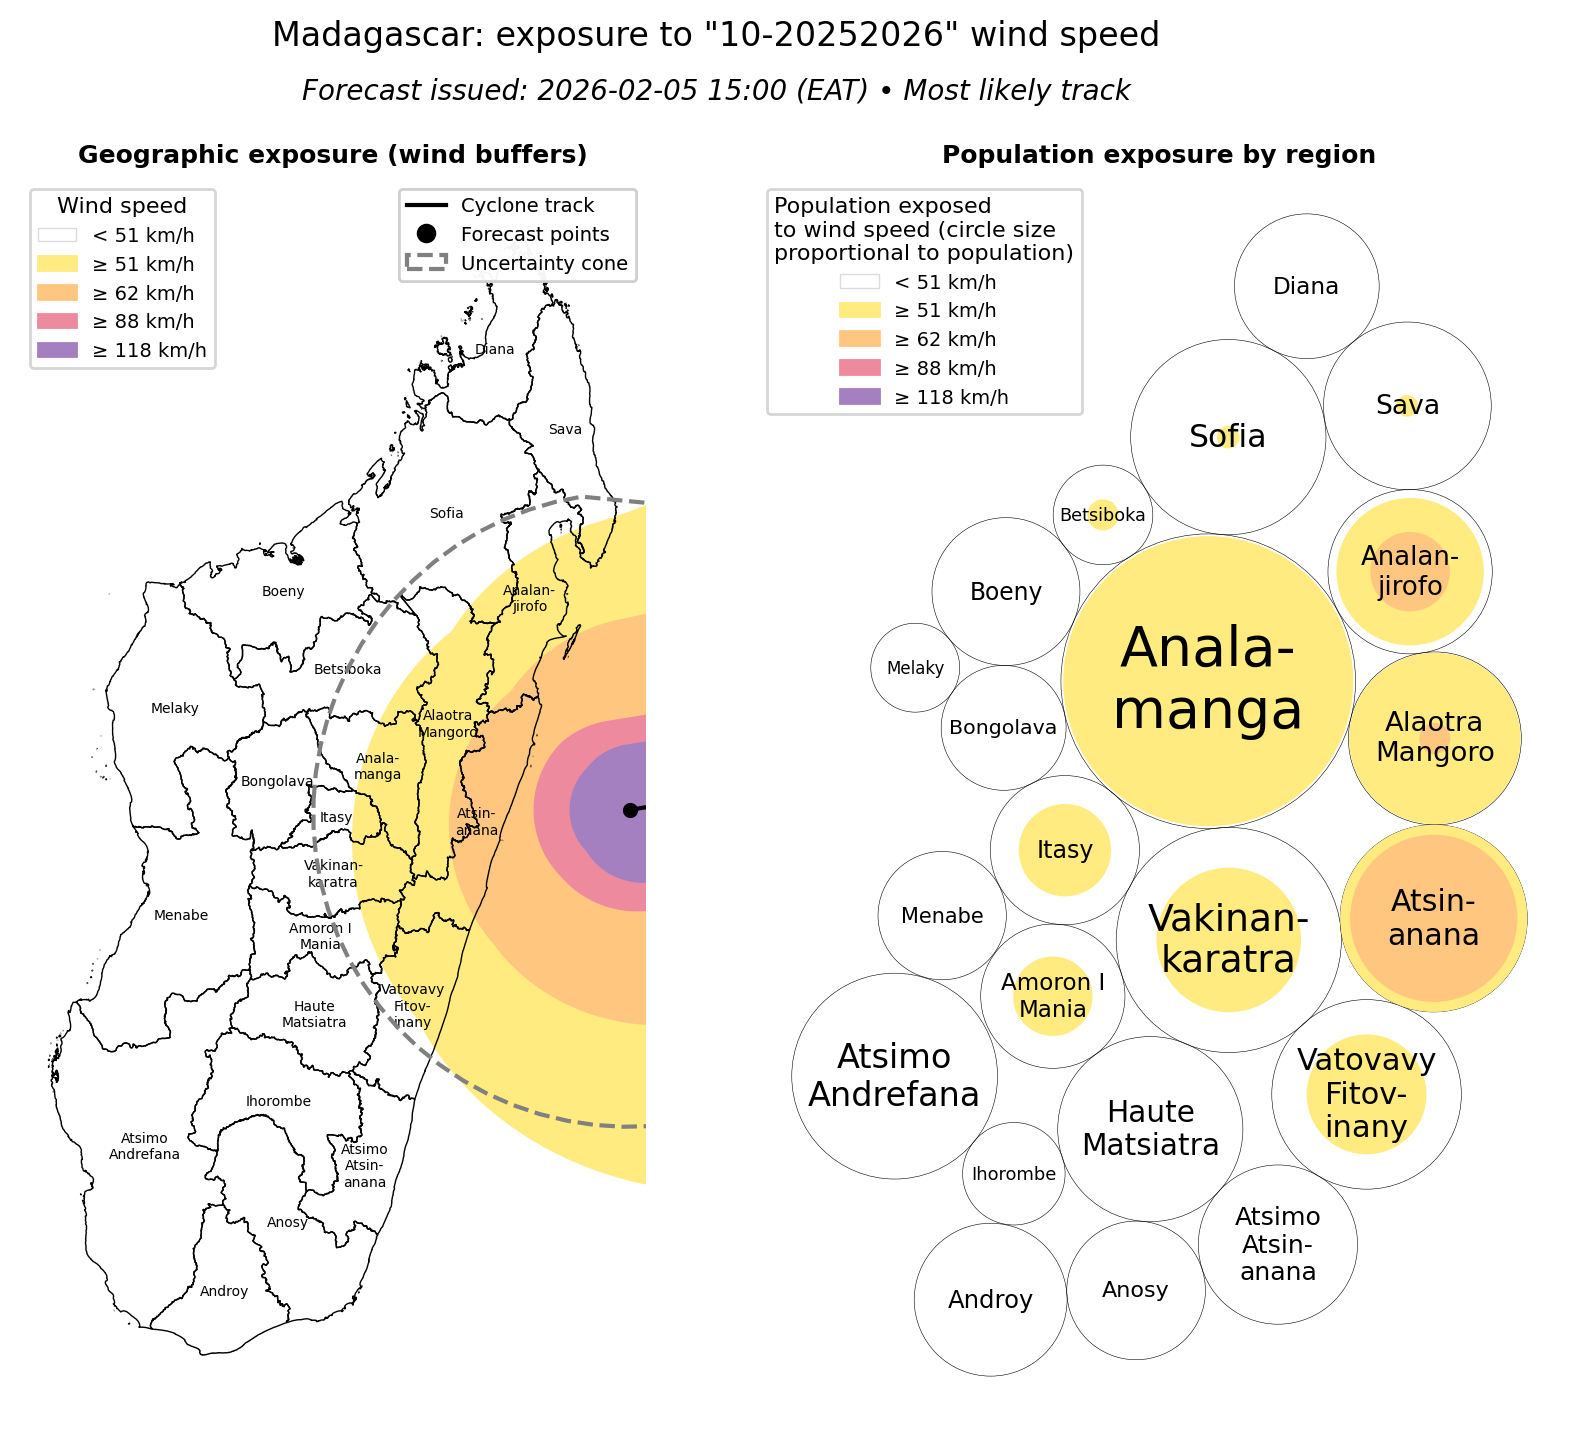

In [40]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    figsize=(12, 8),
    dpi=200,
)

fig_size = (9, 8)

plot_wind_buffers(
    adm1,
    gdf_buffers,
    colors=colors,
    speed_unit="km/h",
    speed_col="speed_kmh",
    ax=ax1,
    fig_size=fig_size,
    show_labels=True,
)

xs = records.geometry.x.values
ys = records.geometry.y.values

# line first (under points)
ax1.plot(
    xs,
    ys,
    color="black",
    linewidth=1.5,
    zorder=9,
)

# points on top
records.plot(
    ax=ax1,
    color="black",
    markersize=20,
    zorder=10,
)

gpd.GeoSeries([uncertainty_cone], crs=adm1.crs).plot(
    ax=ax1,
    facecolor="none",
    edgecolor="grey",
    linewidth=1.5,
    linestyle="--",
    zorder=10,
)

existing_legend = ax1.get_legend()
if existing_legend is not None:
    ax1.add_artist(existing_legend)

# --- build proxy artists for track & cone ---
track_handle = Line2D(
    [0],
    [0],
    color="black",
    linewidth=1.5,
    label="Cyclone track",
)

points_handle = Line2D(
    [0],
    [0],
    marker="o",
    linestyle="none",
    color="black",
    markersize=6,
    label="Forecast points",
)

cone_handle = Patch(
    facecolor="none",
    edgecolor="grey",
    linewidth=1.5,
    linestyle="--",
    label="Uncertainty cone",
)

# --- second legend ---
legend_track = ax1.legend(
    handles=[track_handle, points_handle, cone_handle],
    loc="upper right",
    fontsize=7,
    frameon=True,
)

ax1.add_artist(legend_track)

ax1.set_title(
    "Geographic exposure (wind buffers)",
    fontsize=9,
    fontweight="bold",
)

plot_bullseye_exposures(
    template_df,
    df_exp,
    label_col="adm_label",
    id_col="adm1_src",
    speed_col="speed_kmh",
    min_font=6,
    max_font=20,
    speeds_order=colors.keys(),
    colors=colors,
    speed_unit="km/h",
    ax=ax2,
    fig_size=fig_size,
)

ax2.set_title(
    "Population exposure by region",
    fontsize=9,
    fontweight="bold",
)

fig.suptitle(
    f'Madagascar: exposure to "{fc_details["cyclone_name"]}" wind speed',
    fontsize=12,
    y=0.98,
)

fig.text(
    0.5,
    0.93,
    f"Forecast issued: {issued_time_str} (EAT) • Most likely track",
    ha="center",
    fontsize=10,
    style="italic",
)

fig.subplots_adjust(wspace=-0.2)